In [1]:
import sys
sys.path.append("../../..")
sys.path.append("../..")

In [2]:
import os
import glob

import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import logomaker
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm

from Bio import SeqIO
import fcgr
from tqdm import tqdm

import utility


In [3]:

# Adjusted mpl.rcParams['font.size'] for potential impact on logomaker characters
mpl.rcParams['pdf.fonttype'] = 42    # Use Truetype (Type 42) instead of Type 3
mpl.rcParams['ps.fonttype'] = 42    # Same for PS/EPS output
mpl.rcParams['font.size'] = 6       # Changed from 1 to 6


In [4]:

# Set default font to Arial
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.serif'] = ['Arial']
plt.rcParams['font.sans-serif'] = ['Arial'] # Fallback if Arial isn't found in serif
plt.rcParams['mathtext.fontset'] = 'cm' # For LaTeX-like math text, often pairs well with Times New Roman

In [5]:



# 1. Define sequence and mutation
seq_str = "AACGGCATGCAAAGGATCC"  # length 19
L = len(seq_str)
center_idx = L // 2  # 9 (0-indexed)

ref_base = seq_str[center_idx] # 'G'
alt_base = 'T'
gene_name = "MYC"
pos = 200

# 2. Build Matrices for separate Ref and Alt contributions and for heatmap
bases = ['A', 'C', 'G', 'T']
b2i = {b: i for i, b in enumerate(bases)}

# --- For LOGO: Adjusting proportions of Ref and Alt at center ---
mat_ref_logo = np.zeros((L, 4), dtype=float)
mat_alt_logo = np.zeros((L, 4), dtype=float)

# Populate reference logo matrix (normal 1 for all bases)
for i, b in enumerate(seq_str):
    mat_ref_logo[i, b2i[b]] = 1.0 # Default height 1.0

ref_logo_proportion = 1 # Smaller height for ref
alt_logo_proportion = 1 # Bigger height for alt
# Total height at center will be 0.5 + 1.5 = 2.0

# Reset the center for ref_logo matrix to its proportional height
mat_ref_logo[center_idx, b2i[ref_base]] = ref_logo_proportion

# Set alt_logo matrix only for the alt base at center with its proportional height
mat_alt_logo[center_idx, b2i[alt_base]] = alt_logo_proportion


# --- For HEATMAP: Distinguishing Ref and Alt contribution values (Using -1, 0, 1, 2 for colors) ---
mat_heatmap_values = np.zeros((L, 4), dtype=float)

for i, b in enumerate(seq_str):
    if i != center_idx:
        mat_heatmap_values[i, b2i[b]] = 1 # Wild-type base
    else:
        # At the center, distinguish ref and alt
        mat_heatmap_values[i, b2i[ref_base]] = 2 # Reference base specific value
        mat_heatmap_values[i, b2i[alt_base]] = -1 # Alternate base specific value

# Create DataFrames
positions = range(-center_idx, L - center_idx) # -9 to +9

df_heatmap = pd.DataFrame(mat_heatmap_values, index=positions, columns=bases)
# Fill any potential NaN values with 0
df_heatmap = df_heatmap.fillna(0)

df_logo_ref = pd.DataFrame(mat_ref_logo, index=positions, columns=bases)
df_logo_alt = pd.DataFrame(mat_alt_logo, index=positions, columns=bases)




# --- Heatmap (Top Panel - ax[0]) ---
# Colormap Definition for -1, 0, 1, 2 values
colors_heatmap = ["#FCB9AA", "#ECEAE4", "#A2E1DB", "#55CBCD"]
nodes_heatmap = [0.0, 1/3, 2/3, 1.0]

cmap_heatmap = LinearSegmentedColormap.from_list(
    "heatmap_custom_multi_value",
    list(zip(nodes_heatmap, colors_heatmap))
)

bounds_heatmap = [-1.5, -0.5, 0.5, 1.5, 2.5]
norm_heatmap = BoundaryNorm(bounds_heatmap, cmap_heatmap.N)


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

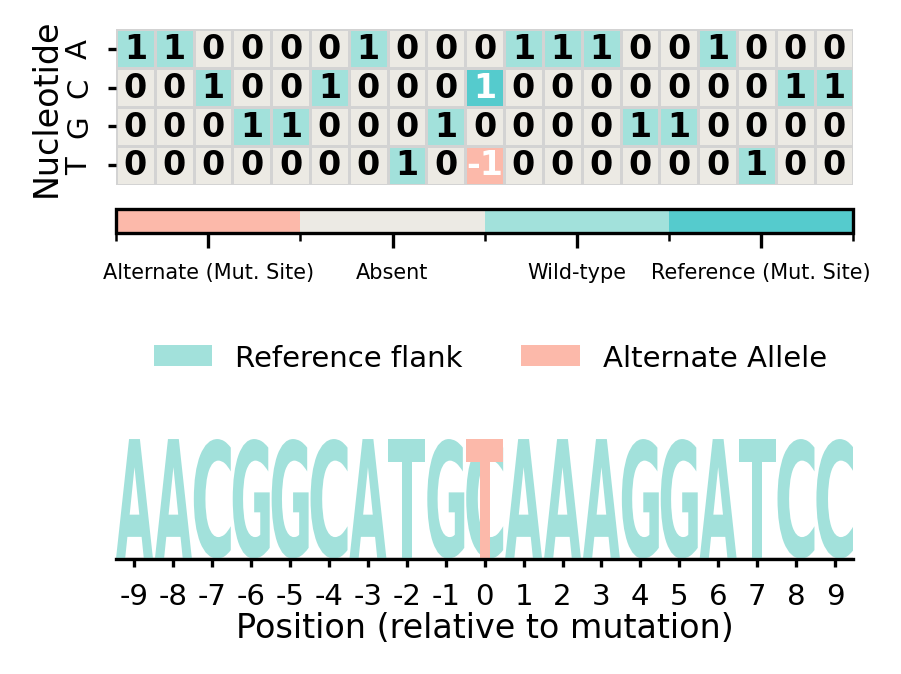

In [6]:
# --- Visualization ---
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(3, 3), dpi=300, 
    gridspec_kw={'height_ratios': [2, 1]}
)


im = sns.heatmap(
    df_heatmap.T, # Transpose for Nucleotide on Y, Position on X
    ax=ax[0],
    cmap=cmap_heatmap,
    norm=norm_heatmap, # Apply the BoundaryNorm for discrete mapping
    cbar=False, # We'll draw a custom discrete colorbar
    linecolor="lightgray",
    linewidths=0.25,
    xticklabels=False, # No xticklabels for heatmap
    yticklabels=True,
    square=True
)

# Add text annotations to heatmap cells - DISPLAYS '0', '1', or '-1'
for y in range(df_heatmap.T.shape[0]):
    for x in range(df_heatmap.T.shape[1]):
        value = df_heatmap.T.iloc[y, x]
        text_color = 'black'
        text_to_display = ''

        if value == -1: # For red background
            text_color = 'white'
            text_to_display = '-1'
        elif value == 0: # For white background
            text_color = 'black'
            text_to_display = '0'
        elif value == 1: # For light green background
            text_color = 'black'
            text_to_display = '1'
        elif value == 2: # For medium green background
            text_color = 'white'
            text_to_display = '1'

        if text_to_display != '':
            ax[0].text(x + 0.5, y + 0.5, text_to_display,
                       ha='center', va='center', color=text_color,
                       fontsize=8, weight='bold')

ax[0].set_ylabel("Nucleotide", fontsize=8, labelpad=0.5)
# ax[1].set_ylabel("Nucleotide", fontsize=8, labelpad=0.5)
ax[0].tick_params(axis='x', labelsize=0, length=0) # Remove x-ticks and labels for ax[0]
ax[0].tick_params(axis='y', labelsize=8) # Keep y-tick labels for heatmap

# Highlight the center column in heatmap
ax[0].axvspan(center_idx - 0.5, center_idx + 0.5, color='gold', alpha=0.3, zorder=0)


cbar_tick_positions = [-1.0, 0.0, 1.0, 2.0]
cbar_labels = ['Alternate (Mut. Site)', 'Absent', 'Wild-type', 'Reference (Mut. Site)']

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_heatmap, cmap=cmap_heatmap),
                    ax=ax[0],
                    orientation="horizontal",
                    pad=0.05, # Increased pad to place it above ax[0]
                    aspect = 30,
                    ticks=cbar_tick_positions)
cbar.set_ticklabels(cbar_labels, fontsize=5)
# cbar.set_label("Encoding", fontsize=7, labelpad=2)

# --- Remove top and right axis lines for Heatmap ---
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)


# --- Sequence Logo (Bottom Panel - ax[1]) ---
# Custom light green color scheme for reference logo
custom_green_scheme = {
    'A': '#A2E1DB',
    'C': '#A2E1DB',
    'G': '#A2E1DB',
    'T': '#A2E1DB',
}

# Removed font_size from here as it's not a valid parameter for logomaker.Logo directly
logo_ref_layer = logomaker.Logo(df_logo_ref, ax=ax[1],
                                 color_scheme= custom_green_scheme,
                                 vpad=0.01,
                                 font_name='Arial')

# Draw the alternate logo on top (red and bigger)
# Removed font_size from here as it's not a valid parameter for logomaker.Logo directly
logo_alt_layer = logomaker.Logo(df_logo_alt, ax=ax[1],
                                 color_scheme="#FCB9AA",
                                 vpad=0.01,
                                 font_name='Arial')



# Adjust y-axis limits. Max height is 1.5 (from alt_logo_proportion)
ax[1].set_ylim(0, 2.0) # Ensure some buffer for better visual

# ax[1].set_ylabel("Encoding Value", fontsize=8, labelpad=8)
ax[1].set_xlabel("Position (relative to mutation)", fontsize=8, labelpad=0.2)

# Show x-tick labels for ax[1] (Sequence Logo)
ax[1].set_xticks(positions)
ax[1].set_xticklabels(positions, fontsize=8)
ax[1].tick_params(axis='x', labelsize=8, rotation=0)

# Remove y-tick labels for ax[1]
ax[1].tick_params(axis='y', labelsize=0, length=0)
ax[1].set_yticks([]) # Explicitly remove y-tick positions


# Custom legend for the logo section
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#A2E1DB', label='Reference flank'),
    Patch(facecolor='#FCB9AA', label='Alternate Allele')
]
ax[1].legend(handles=legend_elements, loc='upper right', fontsize=7, frameon=False, ncol = 2, title_fontsize=7)

# --- Remove top and right axis lines for Logo ---
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False) # Hide left spine as y-ticks are gone

# This loop iterates through any existing matplotlib Text objects on the *axis*
# It won't directly affect characters drawn by logomaker which are typically PathCollection objects.
for text_obj in ax[1].texts:
    text_obj.set_fontsize(5)

ax[0].tick_params(axis='both', which='major', labelsize=7, length=2, direction='out')
# 2. Turn x-axis tick marks on (only bottom)
ax[1].tick_params(
    axis='x',
    which='major',
    bottom=True,   # enable bottom tick-line
    top=False,     # disable top tick-line
    labelsize=7,
    length=2,
    direction='out'
)
plt.tight_layout()
# plt.savefig("Input visualization.pdf", dpi = 300, bbox_inches='tight', pad_inches=0.2)